In [36]:
import os
import shutil
import cv2
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D, GlobalAveragePooling2D, Concatenate, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50

from tensorflow.keras import layers
from tensorflow.keras.regularizers import l2

from keras.metrics import Recall,Precision
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
# from keras import models, layers
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from pathlib import Path
from sklearn.metrics import classification_report, confusion_matrix

from IPython.core.interactiveshell import InteractiveShell

In [37]:
metadata_df = pd.read_csv('/kaggle/input/clinical-metadata/cleaned_metadata.csv')

In [38]:
cleaned_df = metadata_df.drop_duplicates(subset=['NewPatientID'], keep='first')
cleaned_metadata_df = cleaned_df.iloc[:, :10]

In [39]:
import os
from pathlib import Path
import pandas as pd

def load_dataset_with_parent_labels(root_path):

    root_path = Path(root_path)
    T_data = []
    M_data = []
    N_data = []
    test=True
    for parent_dir in root_path.iterdir():
        if parent_dir.is_dir(): 
            if parent_dir.name == 'T':
                for subcat in parent_dir.iterdir():
                    label = subcat.name.split("-")[-1] 
                    if label in ["T1a", "T1c", "T4"] or 'Fused' in subcat.name:
                        for img_path in subcat.glob('*.png'):
                            if not img_path.stem.endswith('GT'):
                                patient_id = str(img_path).split("-")[-3]
                                
                                corr_metadata = cleaned_metadata_df[cleaned_metadata_df['NewPatientID'] == str(patient_id)]
                                if len(corr_metadata) == 0:
                                    continue
                                T_data.append({
                                    'path': str(img_path),
                                    'label': label,
                                    'Age': corr_metadata['Age'].iloc[0],
                                    'Sex': corr_metadata['Sex'].iloc[0],
                                    'weight (kg)': corr_metadata['weight (kg)'].iloc[0],
                                    'T-Stage':corr_metadata['T-Stage'].iloc[0],
                                    'N-Stage':corr_metadata['N-Stage'].iloc[0],
                                    'M-Stage':corr_metadata['M-Stage'].iloc[0],
                                    'Histopathological grading':str(corr_metadata['Histopathological grading'].iloc[0]),
                                    'Smoking History':corr_metadata['Smoking History'].iloc[0]
                                    })

                T_df = pd.DataFrame(T_data)                        

            elif parent_dir.name == "M":
                for subcat in (parent_dir/"Fused_PT_CT").iterdir():
                    label = subcat.name.split("-")[-1] 
                    for img_path in subcat.glob('*.png'):
                        if not img_path.stem.endswith('GT'):
                            patient_id = str(img_path).split("-")[-3]
                            
                            corr_metadata = cleaned_metadata_df[cleaned_metadata_df['NewPatientID'] == str(patient_id)]
                            if len(corr_metadata) == 0:
                                continue
                            M_data.append({
                                'path': str(img_path),
                                'label': label,
                                'Age': corr_metadata['Age'].iloc[0],
                                'Sex': corr_metadata['Sex'].iloc[0],
                                'weight (kg)': corr_metadata['weight (kg)'].iloc[0],
                                'T-Stage':corr_metadata['T-Stage'].iloc[0],
                                'N-Stage':corr_metadata['N-Stage'].iloc[0],
                                'M-Stage':corr_metadata['M-Stage'].iloc[0],
                                'Histopathological grading':str(corr_metadata['Histopathological grading'].iloc[0]),
                                'Smoking History':corr_metadata['Smoking History'].iloc[0]
                                })

                M_df = pd.DataFrame(M_data)

            elif parent_dir.name == "N":
                for subcat in parent_dir.iterdir():
                    if 'Fused' in subcat.name:
                        label = subcat.name.split("-")[-1]
                        for img_path in subcat.glob('*.png'):
                            if not img_path.stem.endswith('GT'):
                                patient_id = str(img_path).split("-")[-3]
                                
                                corr_metadata = cleaned_metadata_df[cleaned_metadata_df['NewPatientID'] == str(patient_id)]
                                if len(corr_metadata) == 0:
                                    continue
                                N_data.append({
                                    'path': str(img_path),
                                    'label': label,
                                    'Age': corr_metadata['Age'].iloc[0],
                                    'Sex': corr_metadata['Sex'].iloc[0],
                                    'weight (kg)': corr_metadata['weight (kg)'].iloc[0],
                                    'T-Stage':corr_metadata['T-Stage'].iloc[0],
                                    'N-Stage':corr_metadata['N-Stage'].iloc[0],
                                    'M-Stage':corr_metadata['M-Stage'].iloc[0],
                                    'Histopathological grading':str(corr_metadata['Histopathological grading'].iloc[0]),
                                    'Smoking History':corr_metadata['Smoking History'].iloc[0]
                                    })

                N_df = pd.DataFrame(N_data)
                
    return T_df, M_df, N_df
    
root_path = "/kaggle/input/augmented-fusion-new/aug images"
T_df, M_df, N_df = load_dataset_with_parent_labels(root_path)
# Verify
print(f"Total images in T: {len(T_df)}")
print("Label distribution:")
print(T_df['label'].value_counts()) 

print(f"Total images in M: {len(M_df)}")
print("Label distribution:")
print(M_df['label'].value_counts()) 

print(f"Total images in N: {len(N_df)}")
print("Label distribution:")
print(N_df['label'].value_counts()) 

Total images in T: 13653
Label distribution:
label
T1a    1976
T2b    1956
T4     1903
T3     1857
T1c    1770
T2a    1548
T1b    1518
T1     1125
Name: count, dtype: int64
Total images in M: 6431
Label distribution:
label
M1b    1920
M1c    1859
M1     1482
M1a    1170
Name: count, dtype: int64
Total images in N: 4899
Label distribution:
label
N2    1989
N3    1735
N1    1175
Name: count, dtype: int64


# getting the image classification pre-trained model

In [40]:
from tensorflow.keras.models import load_model

#          EfficientNet Models
base_cnn_T = load_model('/kaggle/input/t_classification/keras/default/1/T_model.h5')
base_cnn_M = load_model('/kaggle/input/m_model/keras/default/1/M_model.h5')
base_cnn_N = load_model('/kaggle/input/n_classification_moddel/keras/default/1/N_model.h5')



In [41]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# debugging_df,_ = train_test_split(df, train_size=0.2, random_state=42, stratify=df['label'])


train_df, test_df = train_test_split(N_df, test_size=0.2, random_state=42, shuffle = True, stratify=N_df['label'])
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42, stratify=train_df['label'])

def preprocess_data(df):
    # Extract metadata (numerical + categorical)
    numerical_cols = ["Age", "weight (kg)", "Smoking History"]  # Add other numerical columns
    categorical_cols = ["Sex", "T-Stage", "M-Stage", "N-Stage", "Histopathological grading"]  # Add other categorical columns

    numerical = df[numerical_cols].values
    categorical = df[categorical_cols].values
    
    scaler = StandardScaler()
    numerical_scaled = scaler.fit_transform(numerical)
    numerical_df = pd.DataFrame(numerical_scaled, columns=numerical_cols, index=df.index)

    # One-hot encode categorical
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    categorical_encoded = encoder.fit_transform(categorical)
    categorical_columns = encoder.get_feature_names_out(categorical_cols)
    categorical_df = pd.DataFrame(categorical_encoded, columns=categorical_columns, index=df.index)

    processed_df = pd.concat(
        [df[['path', 'label']], numerical_df, categorical_df],
        axis=1
    )
    return processed_df

train_df = preprocess_data(train_df)
val_df = preprocess_data(val_df)
test_df = preprocess_data(test_df)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [42]:
from tensorflow.keras.layers import Layer, Dense, Multiply, Concatenate, Softmax

class CrossModalAttention(Layer):
    def __init__(self, units=64, **kwargs):
        super(CrossModalAttention, self).__init__(**kwargs)
        self.units = units
        
    def build(self, input_shapes):
        img_shape, meta_shape = input_shapes
        self.img_feat_dim = img_shape[-1]
        self.meta_dim = meta_shape[-1]
        
        # Transformation
        self.W_img = Dense(self.units)
        self.W_meta = Dense(self.units)
        self.V = Dense(1, activation='tanh')
        
    def call(self, inputs):
        img_features, meta_features = inputs
        
        # Transform features to common space
        h_img = self.W_img(img_features)  
        h_meta = self.W_meta(meta_features) 
        
        # Compute attention scores 
        h_img_exp = tf.expand_dims(h_img, 1)  
        h_meta_exp = tf.expand_dims(h_meta, 1)
        
        # Broadcastable addition
        combined = tf.nn.tanh(h_img_exp + h_meta_exp)  
        scores = self.V(combined) 
        scores = tf.squeeze(scores, axis=[-1])
        
        # Attention weights
        attn_weights = tf.nn.softmax(scores, axis=1)
        
        # Apply attention
        img_expanded = tf.expand_dims(img_features, 1) 
        attended = tf.matmul(
            attn_weights[:, :, None], 
            img_expanded  
        )  
        
        attended = tf.squeeze(attended, axis=1) 
        
        # Combine features
        fused = Concatenate()([img_features, attended, meta_features])
        return fused

In [43]:
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from contextlib import redirect_stdout
import io


def build_metadata_model(input_shape):
    meta_input = Input(shape=(input_shape,))
    x = Dense(64, activation="relu")(meta_input)
    x = Dense(16, activation="relu")(x)
    return Model(inputs=meta_input, outputs=x)


def extract_combined_features(image_paths, metadata, labels, batch_size=64):
    num_samples = len(image_paths)
    combined_features = []
    combined_labels = []
    
    metadata_model = build_metadata_model(metadata.shape[1])
    feature_extractor = Model(
        inputs=base_cnn_N.input,
        outputs=base_cnn_N.layers[-2].output
    )
    
    for i in range(0, num_samples, batch_size):
        batch_paths = image_paths[i:i+batch_size]
        batch_meta = metadata[i:i+batch_size]
        batch_labels = labels[i:i+batch_size]
        
        # Load and preprocess images
        batch_images = np.array([
            tf.keras.applications.densenet.preprocess_input(
                tf.keras.preprocessing.image.img_to_array(
                    tf.keras.preprocessing.image.load_img(p, target_size=(224, 224))
                )
            ) for p in batch_paths
        ])
        
        # Extract features
        img_features = feature_extractor.predict(batch_images, verbose=0)
        meta_features = metadata_model.predict(batch_meta, verbose=0)
        
        # Apply attention fusion
        fused_batch = CrossModalAttention(units=64)([img_features, meta_features])
        
        combined_features.append(fused_batch)
        combined_labels.append(batch_labels)
    
    # Stack all batches
    return np.vstack(combined_features), np.concatenate(combined_labels)


X_train, y_train = extract_combined_features(train_df['path'].values, train_df.drop(columns=['path','label']), train_df['label'])
X_val, y_val = extract_combined_features(val_df['path'].values, val_df.drop(columns=['path','label']), val_df['label'])
X_test, y_test = extract_combined_features(test_df['path'].values, test_df.drop(columns=['path','label']), test_df['label'])

In [44]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(y_train)
val_labels_encoded = label_encoder.transform(y_val) 
test_labels_encoded = label_encoder.transform(y_test) 

In [50]:
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback

input_shape = X_test.shape[1]
model = Sequential([
    Input(shape=(input_shape,)),
    Dense(256, activation="relu"),
    # Dropout(0.2),
    Dense(256, activation="relu"),
    Dense(64, activation="relu"),
    Dense(32, activation="relu"),
    Dense(3, activation="softmax")
])

model.compile(tf.keras.optimizers.Adam(learning_rate=5e-5), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(
    x=X_train,
    y=train_labels_encoded,  
    validation_data=(X_val, val_labels_encoded),
    epochs=15,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.6, min_delta=0.005, patience=2, min_lr=1e-6, verbose=0)
    ]
)

Epoch 1/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.6021 - loss: 0.8866 - val_accuracy: 0.9745 - val_loss: 0.2042 - learning_rate: 5.0000e-05
Epoch 2/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9705 - loss: 0.1629 - val_accuracy: 0.9796 - val_loss: 0.0997 - learning_rate: 5.0000e-05
Epoch 3/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9697 - loss: 0.0994 - val_accuracy: 0.9770 - val_loss: 0.0755 - learning_rate: 5.0000e-05
Epoch 4/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9695 - loss: 0.0828 - val_accuracy: 0.9732 - val_loss: 0.0687 - learning_rate: 5.0000e-05
Epoch 5/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9697 - loss: 0.0734 - val_accuracy: 0.9770 - val_loss: 0.0660 - learning_rate: 5.0000e-05
Epoch 6/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9697 - loss: 0.0729 - val_accuracy: 0.9770 - val_loss: 0.0652 - learning_rate: 5.0000e-05
Epoch 7/15
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9712 - loss

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

          N1       0.97      1.00      0.98       235
          N2       0.99      0.97      0.98       398
          N3       0.97      0.97      0.97       347

    accuracy                           0.98       980
   macro avg       0.97      0.98      0.98       980
weighted avg       0.98      0.98      0.98       980



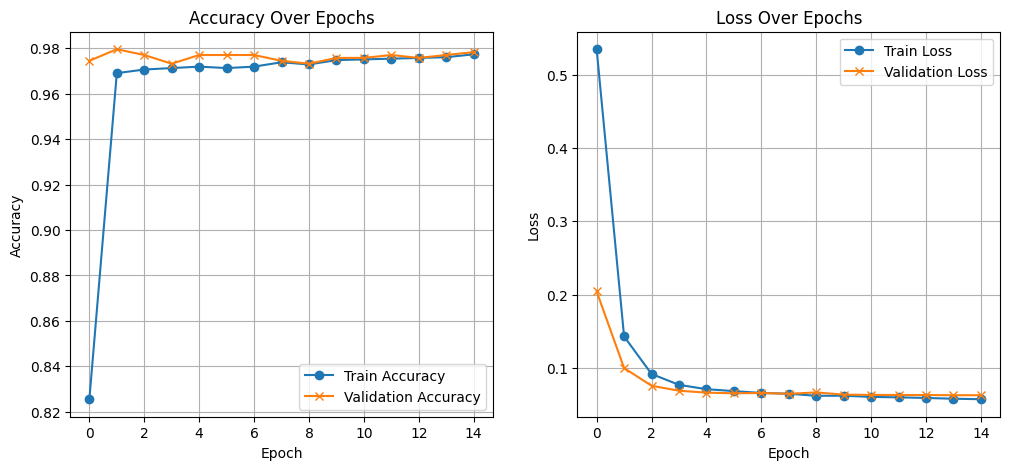

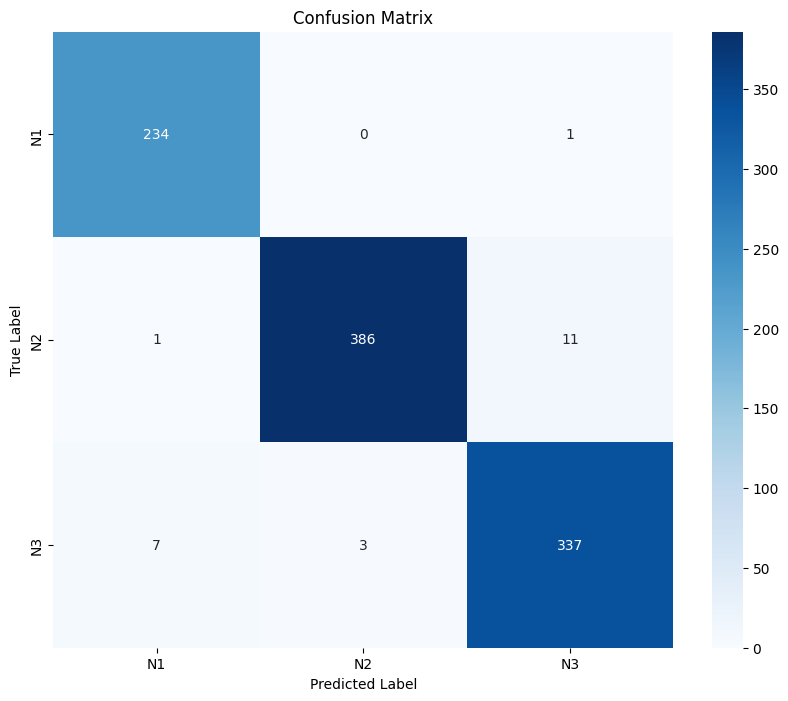


Saved evaluation results to 'evaluation_results_N'


In [52]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def evaluate(model, test_features, test_labels, label_encoder, history,  output_dir):

    os.makedirs(output_dir, exist_ok=True)
    
    pred_probs = model.predict(test_features)
    pred_labels = np.argmax(pred_probs, axis=1)
    
    true_labels_str = label_encoder.inverse_transform(test_labels)
    pred_labels_str = label_encoder.inverse_transform(pred_labels)
    class_labels = label_encoder.classes_
    
    report = classification_report(true_labels_str, pred_labels_str, target_names=class_labels)
    print(report)
    with open(os.path.join(output_dir, "classification_report.txt"), "w") as f:
        f.write(report)
    
    if history is not None:
        plt.figure(figsize=(12, 5))
        
        # Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='x')
        plt.title('Accuracy Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)

        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss', marker='o')
        plt.plot(history.history['val_loss'], label='Validation Loss', marker='x')
        plt.title('Loss Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(output_dir, "accuracy_loss_plot.png"))
        plt.show()

        plt.tight_layout()
        plt.close()
    
    # Confusion matrix
    cm = confusion_matrix(true_labels_str, pred_labels_str)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, 
                yticklabels=class_labels, cmap='Blues')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    cm_plot_path = os.path.join(output_dir, "confusion_matrix.png")
    plt.savefig(cm_plot_path)
    plt.show()
    plt.close()

    print(f"\nSaved evaluation results to '{output_dir}'")

evaluate(model, X_test, test_labels_encoded, label_encoder, history, output_dir="evaluation_results_N")